<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/VGG_Face_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [ ]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 525 (delta 110), reused 177 (delta 88), pack-reused 307
Receiving objects: 100% (525/525), 31.86 MiB | 14.71 MiB/s, done.
Resolving deltas: 100% (287/287), done.
     - 45.5 MB 20.0 MB/s 0:00:03
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30850 sha256=daee89a1f6887f0aa328251428de925d32cf20c998efec4bba3820556dd740c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9j8z1f59/wheels/00/aa/d0/0e9ee9f905608038b67cb2daa7b5694046d3dac03d042e27ed
Successfully built keras-vis


Unpack the items

In [ ]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/merge
!unzip -q /content/drive/My\ Drive/vggface_files

# Load libraries
Load the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils  import load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [ ]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im)
    return data

(8, 80, 224, 224, 3) (8, 40, 224, 224, 3)
(8, 80, 224, 224, 3) (8, 40, 224, 224, 3)


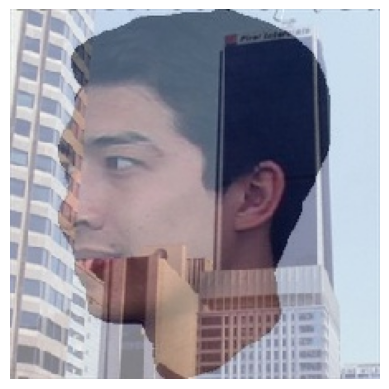

In [ ]:
# Merged images load
data_train = [[]  for i in range(8)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
#data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
#data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[4] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
#data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
#data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)

data_test = [[]  for i in range(8)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
#data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
#data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[4] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
#data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
#data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
#reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
#reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
#reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
#reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(8)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
#reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
#reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[4] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
#reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
#reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



# Model
Call the base model and the top model here

### Model Architecture

In [ ]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet
# vgg = VGG16(weights=None,
#               include_top=False,input_shape = [224,224,3])

# output = vgg.output
# x = Flatten()(output)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(2622,activation = 'softmax')(x)

# model2 = Model(inputs = vgg.input, outputs = x)
# model2.load_weights('/content/vggface_files/vggface_weights.h5')
# model2.summary()

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])

# for layer in range(13):
#   model.layers[layer].set_weights(model2.layers[layer].get_weights())


categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it)
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it)
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest)

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
#top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
5/5 [==============================] - 1s 132ms/step
Train Time: 1.0364489555358887
3/3 [==============================] - 0s 113ms/step
Test Time: 0.5842626094818115


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 top_dense1 (Dense)          (None, 4096)              102764544 
                                                                 
 predictions (Dense)         (None, 2)                 8194      
                                                                 
Total params: 102772738 (392.05 MB)
Trainable params: 102772738 (392.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [ ]:
acc = np.zeros((2,4))
for imtype in range(2):
  for cat in range(0,4):
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 4])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
    print(train_it.shape,test_it.shape)

    '''
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:]))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))

    top_model.add(Dense(2, activation='softmax',name = 'predictions'))

    top_model.compile(optimizer= Adam(lr=1e-5),
                  loss=losses,
                  metrics=['accuracy'])'''
    start = time.time()
    train_data = model.predict(train_it)
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it)
    print(f'Test Time: {time.time() - start}')

    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

In [ ]:
acc

array([[0.85000002, 0.8125    , 0.86250001, 0.60000002],
       [0.71249998, 0.6875    , 0.80000001, 0.71249998]])

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

In [ ]:
acc[0] = [90,81,77,85]
acc[1] = [68,61,65,70]
print(np.mean(acc))
import seaborn as sns

diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
sns.color_palette('pastel')
sns.set(font_scale=2,style="ticks")
plt.figure(figsize = (4,8),tight_layout = True)
ax = sns.boxplot(data = acc.T )
#ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 20)
ax.set_ylim(50,100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [ ]:
np.mean(acc[0])

83.25

# Tuning Value Calculation

In [ ]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(len(categories)):
  with open ('tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



320

### Calculation of tuning values for each map

In [ ]:
ncats = 4
# to fish out each category tun_activations
labels = np.array([0] * 80 + [1] * 80 + [2] * 80 + [3] * 80)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category,
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] -
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


## Example Tuning Curves

In [ ]:
plt.rcParams['figure.dpi'] = 300

a = np.zeros((4,1))
a[0] = fc[0][2][31]
a[1] = fc[1][2][31]
a[2] = fc[2][2][31]
a[3] = fc[3][2][31]
plt.style.use('default')

plt.figure(figsize = (12,4))
ax = plt.subplot(1,3,1)
plt.plot(a,linewidth = 2,c = '#d62728')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Male','Female','Manmade','Natural'])
ax.set_title('Layer 2, Map 31')
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(3)
ax.spines[['left','bottom']].set_color('#bebebe')
ax.tick_params(axis='y', colors='#7f7f7f',labelsize = 15)
ax.tick_params(axis='x', colors='#7f7f7f')



a[0] = fc[0][6][112]
a[1] = fc[1][6][112]
a[2] = fc[2][6][112]
a[3] = fc[3][6][112]
ax = plt.subplot(1,3,2)
plt.plot(a,linewidth = 2,c = '#d62728')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Male','Female','Manmade','Natural'])
ax.set_title('Layer 6, Map 112')
ax.set_yticks([])
ax.spines[['right', 'top','left']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(3)
ax.spines['bottom'].set_color('#bebebe')
ax.tick_params(axis='both', colors='#7f7f7f')

a[0] = fc[0][11][238]
a[1] = fc[1][11][238]
a[2] = fc[2][11][238]
a[3] = fc[3][11][238]
ax = plt.subplot(1,3,3)
plt.plot(a,linewidth = 2,c = '#d62728')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Male','Female','Manmade','Natural'])
ax.set_title('Layer 11, Map 238')
ax.set_yticks([])

ax.spines[['right', 'top','left']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(3)
ax.spines['bottom'].set_color('#bebebe')
ax.tick_params(axis='both', colors='#7f7f7f')

plt.yticks(fontsize=30)

plt.savefig('imagenet_example_plot.png')  # saves the current figure
plt.savefig('imagenet_example_plot.jpeg')  # saves the current figure

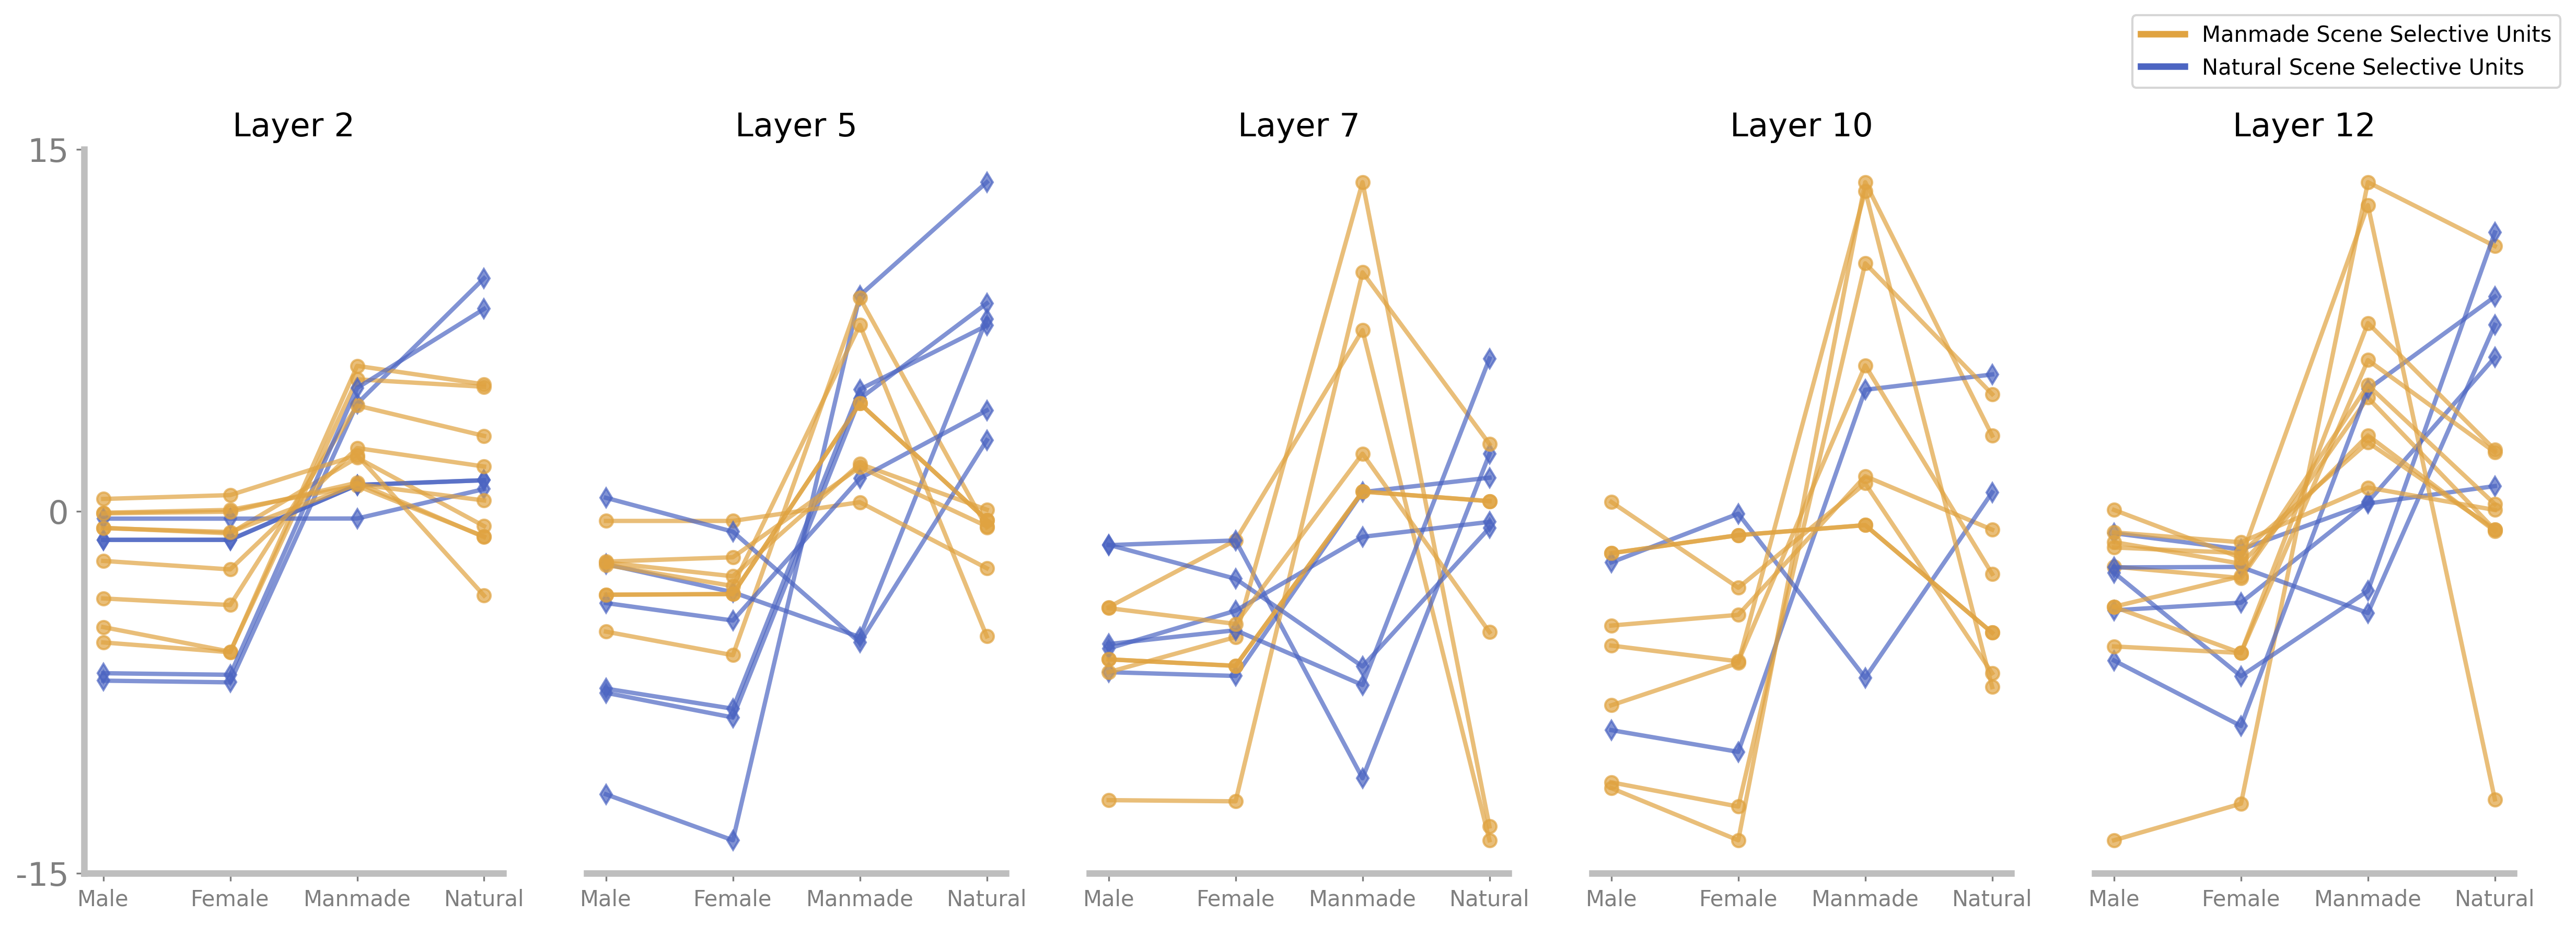

In [ ]:
from matplotlib.lines import Line2D
color1 = '#e0a341'      #ed3232, 944848 for faces
color2 = '#4c65c2'      #edb647, 6b4c0d for scenes
idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat
counter = 1
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize = (20,6),dpi = 300)
for layer in [2,5,7,10,12]:
  ax = plt.subplot(1,5,counter)
  for map in np.random.randint(1,len(fc[cat][layer]),size=20):
    a = np.zeros((4,1))
    a[0] = fc[0][layer][map]
    a[1] = fc[1][layer][map]
    a[2] = fc[2][layer][map]
    a[3] = fc[3][layer][map]

    if idx[layer][map] == 2:
      plt.plot(a,linewidth = 2,c = color1,marker = 'o',alpha = 0.7) #type1 selective
    elif idx[layer][map] == 3:
      plt.plot(a,linewidth = 2,c = color2,marker = 'd',alpha = 0.7) #type2 selective
  ax.set_xticks([0,1,2,3])
  ax.set_xticklabels(['Male','Female','Manmade','Natural'])

  if counter != 1:
    ax.set_yticks([])
    ax.spines[['right', 'top','left']].set_visible(False)
  else:
    ax.set_yticks(np.arange(-15,16,15))
    ax.set_yticklabels(['-15','0','15'],fontsize = 15)
    ax.spines[['right', 'top']].set_visible(False)

  ax.set_title('Layer ' + str(layer),fontsize = 15)
  ax.spines[['left','bottom']].set_linewidth(3)
  ax.spines[['bottom','left']].set_color('#bebebe')
  ax.tick_params(axis='both', colors='#7f7f7f')
  counter = counter + 1
custom_lines = [Line2D([0], [0], color=color1, lw=3),
                Line2D([0], [0], color=color2, lw=3)]
ax.legend(custom_lines,['Manmade Scene Selective Units','Natural Scene Selective Units'],
          bbox_to_anchor=(0.6, 1.2),loc = 'upper center')

plt.savefig('tuning_curves_scenes.png',dpi = 300)  # saves the current figure
plt.savefig('tuning_curves_scenes.jpeg',dpi = 300)  # saves the current figure

In [ ]:
plt.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker = 'o',color='#D65353', lw=3),
                Line2D([0], [0], marker = 'v',color='#F7C45F', lw=3)]
ax = plt.subplot(1,1,1)
ax.legend(custom_lines,['Face Selective Units','Scene Selective Units'],
          bbox_to_anchor=(0.6, 1.2),loc = 'upper center')

### Tuning quality for face and scene images
Modified on March 2024 to find the range of tuning for each subcategory within a category

In [ ]:
tun_q_1 = [[[0 for item in subl] for subl in fc[0]] for cat in range(len(categories))]

for cat in [0,1,2,3]:
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_1[cat][layer][map] < fc[cat][layer][map]:
        tun_q_1[cat][layer][map] = fc[cat][layer][map]



# Get rid of all zeros from the arrays
tun_q_1[0] = [[i for i in temp] for temp in tun_q_1[0] if i >=3]
tun_q_1[1] = [[i for i in temp] for temp in tun_q_1[1] if i !=0]
tun_q_1[2] = [[i for i in temp] for temp in tun_q_1[2] if i !=0]
tun_q_1[3] = [[i for i in temp] for temp in tun_q_1[3] if i !=0]

In [ ]:
plt.rcParams['figure.dpi'] = 300
import scipy.stats as stats

m = np.empty([13])
n = np.empty([13])
merr = np.empty([13])
nerr = np.empty([13])

r1 = np.arange(13)
barW = 0.4
r2 = [x + 0 for x in r1]

for l in range(13):
  m[l] = np.mean(tun_q_1[2][l])
  merr[l] = stats.sem(tun_q_1[2][l])
  n[l] = np.mean(tun_q_1[3][l])
  nerr[l] = stats.sem(tun_q_1[3][l])

ax = plt.subplot(111)


ax.errorbar(r1,m,label='Manmade Scenes',yerr = merr,capsize=2,color = '#6b4c0d',fmt='d',markersize=4)#ed3232, 944848
ax.errorbar(r2,n,label='Natural Scenes',yerr = nerr,capsize=2,color = '#edb647',fmt='o',markersize=4)#edb647,6b4c0d
plt.xticks([r  for r in range(13)], np.arange(1,14),fontsize = 10)
plt.legend(fontsize = 10)
plt.ylabel('Tuning quality')
plt.xlabel('Layer')
ax.set_ylim(0,5.5)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig('imtrain_tun_q_scenes.png')  # saves the current figure
plt.savefig('imtrain_tun_q_scenes.jpeg')  # saves the current figure

In [ ]:
!zip -r /content/plots.zip /content/plots

In [ ]:
calc_neuron_activ = 1
neuron_act = [[np.empty((224,224,64)),
              np.empty((224,224,64)),
              np.empty((112,112,128)),
              np.empty((112,112,128)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512))] for i in range(len(categories))]

if calc_neuron_activ:
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    tun_activ = [[[] for j in range(len(layer_names))] for i in range(len(train_it))]

    start = time.time()
    for imgs,img_tensor in enumerate(train_it):
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        tun_activ[imgs][l] = layer_activation[0]

    neuron_act[cat] = np.mean(tun_activ,0)
    print(f'Elapsed: {time.time() - start}s')
neuron_act = np.array(neuron_act)


In [ ]:
width = 0.4
plt.rcParams['figure.dpi'] = 300

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1
c_scene[2] = 19
c_scene[0] = 25
total_units = np.array([64,64,128,128,256,256,256,512,512,512,512,512,512])
c_face_ratio = np.divide(c_face,total_units)
c_scene_ratio = np.divide(c_scene,total_units)



fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13), c_face_ratio, label='Faces',color = '#D65353')

rects2 = ax.bar(np.arange(13), c_scene_ratio, label='Scenes',color = '#F7C45F',bottom = c_face_ratio)

counter = 0
data = c_face
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() - 0.1,
      round(data[counter]),
      ha='center',
      color='w',
      weight='regular',
      size=12
  )
  counter = counter + 1
  if counter > 12:
    counter = 0
    data = c_scene


ax.axhline(y = 0.5,color = [0.3,0.3,0.3],linestyle = '--')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend(loc = 7,bbox_to_anchor=(1.1, 1.1))

plt.ylim(0,1.05)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','0.2','0.4','0.6','0.8','1'],size = 20)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('Proportion of Maps',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig('facetrain_count.png')  # saves the current figure
plt.savefig('facetrain_count.jpeg')  # saves the current figure

#Gradient Calculations

In [ ]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
top_model.add(Dense(4, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

g_labels_train = to_categorical(labels)
g_labels_test = to_categorical([0]* 40 + [1]*40 + [2]*40 + [3]*40)
g_train = np.vstack((reg_train[0],reg_train[1],reg_train[2],reg_train[3]))
g_test = np.vstack((reg_test[0],reg_test[1],reg_test[2],reg_test[3]))

G_train = model.predict(g_train)
G_test = model.predict(g_test)

history = top_model.fit(x = G_train,  y = g_labels_train,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

out = top_model.evaluate(G_test, g_labels_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
5/5 [==============================] - 0s 4ms/step - loss: 0.7229 - accuracy: 0.8500


In [ ]:
calc_gradient_val = 1
if calc_gradient_val:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(2):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(data_train[i],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_values_cat', 'wb') as fp:
      pickle.dump(cat_grads, fp)

0


<Figure size 432x288 with 0 Axes>

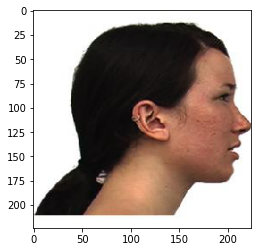

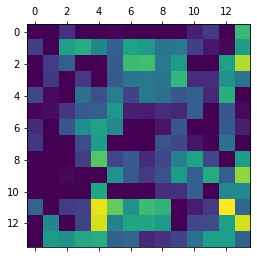

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.cm as cm
import keras
from IPython.display import Image, display

h = calc_avg_gradcam(reg_train[1,3:4,:,:,:],model,top_model)
len(h[0])
img = reg_train[1,3:4,:,:,:]
img = img.reshape(224,224,3)
plt.imshow(img)
plt.matshow(h)
heatmap = np.uint8(255 * h)
# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
#plt.imshow(jet_heatmap,cmap = 'jet')
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.3 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save('x.jpg')

# Display Grad CAM
plt.figure()
#display(Image(superimposed_img))

In [ ]:

def make_gradcam_heatmap(
    img_array, model, layer_name, classifier_layer_names,top_model):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    top_layer_names = [layer.name for layer in top_model.layers]
    conv_layer = model.get_layer(layer_name)
    conv_layer_model = Model(model.inputs, conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = Input(shape=conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        if layer_name in top_layer_names:
          x = top_model.get_layer(layer_name)(x)
        else:
          x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        conv_layer_output = conv_layer_model(img_array)
        tape.watch(conv_layer_output)
        # Compute class predictions
        preds = classifier_model(conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    conv_layer_output = conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return pooled_grads,heatmap

def reduce_catgrad_mean(data):
    reduce_data = [[0 for item in subl] for subl in data[0]]
    for img in range(len(data)):
      for layer in range(len(data[0])):
        for map in range(len(data[0][layer])):
          reduce_data[layer][map] += data[img][layer][map]/len(data)
    return reduce_data

def calc_avg_gradcam(data,model,top_model):
    layer_names_all = [layer.name for layer in model.layers]
    top_layer_names = [layer.name for layer in top_model.layers]

    grad_cat = [[] for i in range(len(data))] #Initialize gradients for each image in cat
    for img in range(len(data)): # Parse each image
      for idx,layer_name in enumerate(layer_names_all):
        if 'conv' in layer_name:
          classifier_layer_names = layer_names_all[idx + 1:] + top_layer_names
          img_tensor = data[img].reshape([1,224,224,3])
          g,h = make_gradcam_heatmap(img_tensor,model,layer_name,classifier_layer_names,top_model)
          grad_cat[img].append(g) #grads has dimensions of layers x no of maps in each layer
      print(img)
    grads = reduce_catgrad_mean(grad_cat) # Reduce to the mean of all the images in cat
    del grad_cat
    return h


In [ ]:
corr_all_1 = st.calc_all_corrcoeff(fc[0:2],cat_grads[0:2])
corr_all_2 = st.calc_all_corrcoeff(fc[2:4],cat_grads[2:4])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


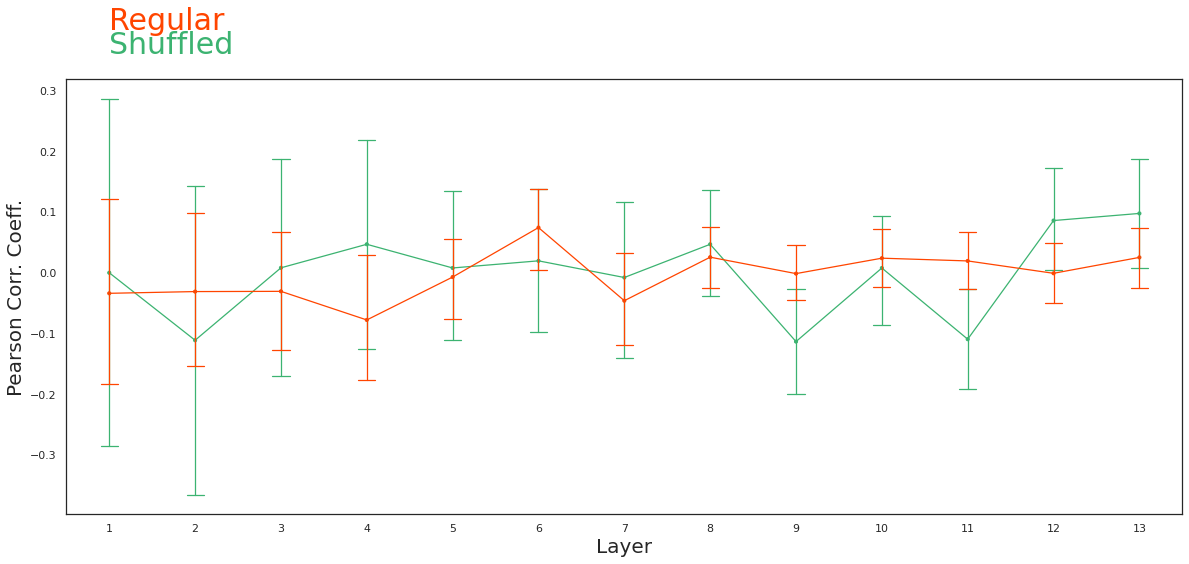

In [ ]:
import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)

for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)
pt.plot_corr(corr_all_1,corr_shuff,figsize = (20,8))

# Neuron level activities

### Calcuation of number of face and scene selective neurons

Text(0.5, 1.0, 'Number of selective neurons, category wise')

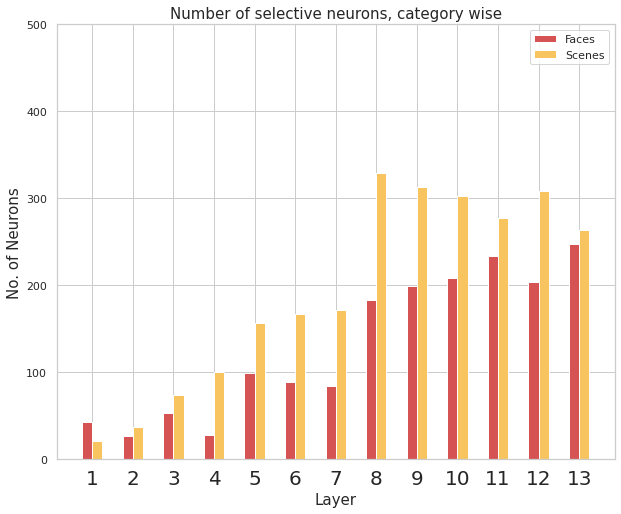

In [ ]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1



fig, ax = plt.subplots(figsize = (10,8))
plt.rcParams['figure.dpi'] = 300

rects1 = ax.bar(np.arange(13) - width/2 , c_face, width, label='Faces',color = '#D65353')
rects2 = ax.bar(np.arange(13) + width/2, c_scene, width, label='Scenes',color = '#F7C45F')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,500)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
vgg = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

output = vgg.output
x = Flatten()(output)
x = Dense(4096,activation = 'relu')(x)
x = Dense(4096,activation = 'relu')(x)
x = Dense(2622,activation = 'softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)
model2.load_weights('/content/vggface_files/vggface_weights.h5')
model2.summary()

model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype):
    """


    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at.
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10

    #conv1_1 & conv1_2
    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)

    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)

    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)

    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)

    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)

    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer]))

    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """


    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """

    epochs = 30
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)


        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations

        get_custom_objects().update({'attnrelu': Activation(attnrelu)})

        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu

        utils.apply_modifications(model)
        model.compile()

        f_train = model.predict(data_train)

        f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)

        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])

        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]

    return t_acc


def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
      beta = np.array(beta)
  return beta

### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths.
PS. This is very heavy and requires hours to finish.


In [ ]:
#@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,0.5): #Calling for different attn strengths
  grand_acc = [[] for i in range(ncats)]
  for cat in range(ncats): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights= None,
                        include_top=False,input_shape = [224,224,3])

    for layer in range(13):
      model.layers[layer].set_weights(model2.layers[layer].get_weights())
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:]))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([13,4,1])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_multi' + str(atstrng),grand_acc)



Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 0s 4ms/step - loss: 1.4961 - accuracy: 0.6500
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 5ms/step - loss: 1.5388 - accuracy: 0.7125
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.4375 - accuracy: 0.8500
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.7381 - accuracy: 0.7625
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.9766 - accuracy: 0.6750
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 1.0685 - accuracy: 0.7375
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 5ms/step - loss: 0.4423 - accuracy: 0.7500
Ca

In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

Text(0, 0.5, 'Avg. acc.')

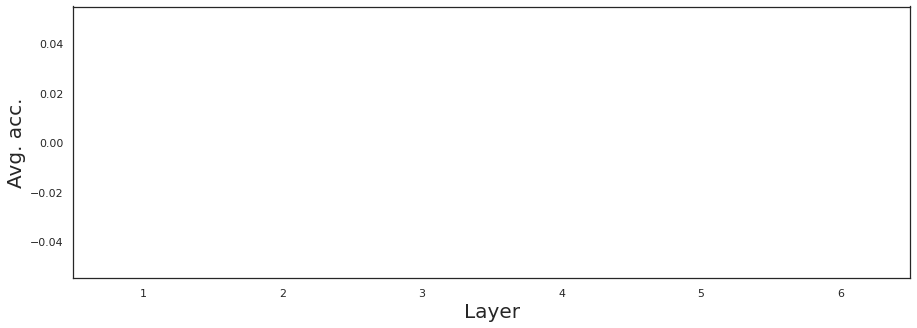

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())


categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 4]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 4]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it)
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it)
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest)

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
#top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)

categories = ['Male','Female','Manmade','Natural']

for cat in range(ncats):

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data

  test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
  print(train_it.shape,test_it.shape)


  start = time.time()
  train_data = model.predict(train_it)
  print(f'Train Time: {time.time() - start}')

  start = time.time()
  test_data = model.predict(test_it)
  print(f'Test Time: {time.time() - start}')

  history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  acc[cat] = out[1]
  print(out)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3275315761566162
Test Time: 0.23416447639465332
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.2986001968383789
Test Time: 0.13538908958435059
Epoch 00004: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.4063 - accuracy: 0.8500
[0.4063255786895752, 0.8500000238418579]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.23165631294250488
Test Time: 0.13665533065795898
Epoch 00002: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.7306 - accuracy: 0.6000
[0.7305806875228882, 0.6000000238418579]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.2292919158935547
Test Time: 0.45503973960876465
Epoch 00026: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4612 - accuracy: 0.7625
[0.4612344205379486, 0.762499988079071]
Category of interest:  Na

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

In [ ]:
acc = [0.70,0.66,0.85,0.74]

gacc = np.load('tun_accuracy_multi0.0.npy')
gacc = np.expand_dims(gacc,0)


for i in np.arange(0,10,0.5):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
#strngs = np.concatenate((strngs,np.arange(1,6,1)))
y = np.amax(gacc,0).T


plt_data = np.zeros((13,4))
for i in range(13):
  for j in range(4):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
sns.set(font_scale=2,style='ticks')
layer = 0
plt.rcParams['figure.dpi'] = 300
f,axes = plt.subplots(2,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 20)
plt.ylabel("Performance Increase (%)",size = 20)
for x in range(2):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14,2))
    axes[x,y].set_xticks(np.arange(0,14,2))
    axes[x,y].set_title(categories[layer],size = 20)
    axes[x,y].set_ylim(-2,35)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    axes[x,y].spines['right'].set_visible(False)
    axes[x,y].spines['top'].set_visible(False)
    layer+=1

np.save('merge_set.npy',plt_data)